<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 04_CoxPHModel

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    
    
+ [Cox Proportional Hazards Modeling](#Cox-Proportional-Hazards-Modeling)


# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [9]:
from collections import OrderedDict
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 14, 6

np.random.seed(0)

## Local Functions

In [3]:
def estimate_cond_mean(S):
    """ Quick & dirty estimate of conditional mean lifetime """
    fstar = -S.diff() / (1-S.iloc[-1,0])
    Sstar = (S-S.iloc[-1,0]) / (1-S.iloc[-1,0])
    llstar = fstar / Sstar
  
    llstar[pd.isnull(llstar)] = 0
    llstar = llstar[np.isfinite(llstar)]
    llstarcs = llstar.cumsum().reset_index()
    llstarcs['timelinediff'] = np.append(llstarcs['timeline'].diff().values[1:],0)
    llstarcs['auc'] = llstarcs['timelinediff'] * llstarcs['KM_estimate']
    return np.nansum(llstarcs['auc']).round()


## Load Data

In [4]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [5]:
print(df.shape)
df.head()

(47252, 11)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,21697,36586,0,SEAGATE,1.5TB,201304,201412
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,26920,42049,0,SEAGATE,1.5TB,201304,201412
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,22036,32614,0,SEAGATE,2.0TB,201305,201407


---

# Cox Proportional Hazards Modelling

### Transform raw dataframe into design matrix

The Cox PH model gives a semi-parametric method of estimating the hazard function at time $t$ given a baseline hazard that's modified by a set of covariates:

$$\lambda(t|X) = \lambda_0(t)\exp(\beta_1X_1 + \cdots + \beta_pX_p) = \lambda_0(t)\exp(\bf{\beta}\bf{X})$$

where $\lambda_0(t)$ is the non-parametric baseline hazard function and $\bf{\beta}\bf{X}$ is a linear parametric model using features of the individuals, transformed by an exponential function.

... we will use the `patsy` package to transform our row-format dataframe into $\bf{X}$. 

Note that by default, the first factor in each feature will be used in the intercept, which sets the _baseline hazard rate_, to which all other factor combinations are compared. In this case, that will be `HGST` and `1.5TB`.

In [41]:
modelspec = 'manufacturer + capacity'

dft = pt.dmatrix(modelspec, df, return_type='dataframe')
design_info = dft.design_info
dft = dft.join(df[['maxhours','failed']])

## NOTE: CoxPHFitter expects reduced-rank design matrix WITHOUT intercept
## https://courses.nus.edu.sg/course/stacar/internet/st3242/handouts/notes3.pdf?
del dft['Intercept']
dft.head().T

diskid,5XW004AJ,5XW004Q0,5XW008MX,5XW00B95,5XW00E5M
manufacturer[T.SEAGATE],1,1,1,1,1
manufacturer[T.WDC],0,0,0,0,0
capacity[T.2.0TB],0,0,0,0,1
capacity[T.3.0TB],0,0,0,0,0
capacity[T.4.0TB],0,0,0,0,0
capacity[T.6.0TB],0,0,0,0,0
maxhours,36586,44471,44471,42049,32614
failed,0,0,0,0,0


**NOTE:**
+ This is a view of the top 5 rows of the design matrix, transposed so it fits easier in view
+ You can see the boolean representation of the feature values for each disk, for example
    + diskid 5XW004AJ is a Seagate 1.5TB drive with 36586 hours of power-on and no failure
    + diskid 5XW00E5M is a Seagate 2.0TB drive with 32614 hours of power-on and no failure


### Fit CoxPH

In [34]:
cx = sa.CoxPHFitter(normalize=False)
cx.fit(df=dft, duration_col='maxhours', event_col='failed'
           ,show_progress=True, include_likelihood=True)

Convergence completed after 8 iterations.


<lifelines.CoxPHFitter: fitted with 47252 observations, 44428 censored>

The `fit()` method has run the CoxPH partial regression and stored the results on the `cx` object

### View the baseline hazard rate

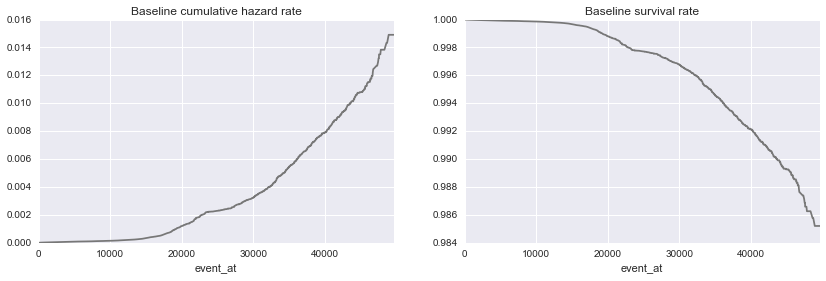

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True, figsize=(14,4))
cx.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
                ,title='Baseline cumulative hazard rate')
cx.baseline_survival_.plot(ax=axes[0,1], legend=False
                ,title='Baseline survival rate')

**Observe:**
+ Here we see our baseline cumulative hazard rate $\Lambda = \sum_t{\lambda_0(t)}$ and the computed baseline survival rate $S = e^{-\Lambda}$
+ The baseline cumulative hazard rate is very modest in this case, since it's set by 1.5TB and HGST drives which appear to be quite reliable.
+ Reading the cumulative baseline hazard rate, we see for example that by 40,000 hours elapsed, the baseline probability of drive failure is 0.008. This seems low, but of course, the baseline will be modified by $exp(\bf{\beta}\bf{X})$.

### View the summary of coefficients

In [35]:
cx.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
manufacturer[T.SEAGATE],3.100713,22.213774,0.074905,41.395366,0.000000e+00,2.953870,3.247556
manufacturer[T.WDC],2.465773,11.772577,0.141731,17.397539,8.612413e-68,2.187924,2.743622
capacity[T.2.0TB],1.203798,3.332752,0.112477,10.702612,9.894919e-27,0.983299,1.424298
capacity[T.3.0TB],2.613823,13.651145,0.079818,32.747221,3.325801e-235,2.457348,2.770299
capacity[T.4.0TB],2.331483,10.293193,0.106084,21.977731,4.703864e-107,2.123516,2.539449
capacity[T.6.0TB],2.005148,7.427189,1.007696,1.989834,4.660918e-02,0.029666,3.980629


The proportional nature of the hazard coefficients can be seen clearly..

**Observe:**
+ Manufacturers:
    + A Seagate drive has a hazard rate 3.10x that of an HGST drive (remember HGST is on the baseline for this model), and a WDC drive has a hazard rate 2.46x that of an HGST drive
    + Adding in the bootstrapped confidence intervals, a Seagate drive would appear to be 2.95x - 3.25x more likely to fail than an HGST drive during the period of our study.
+ Capacities:
    + A 2TB drive would appear to be 0.98x - 1.42x more likely to fail than a 1.5TB drive, mean 1.20x.
    + Looking back to the [Kaplan-Meier model results](../notebooks/03_KaplanMeierModel.ipynb#Lifetime-by-Manufacturer-by-Capacity) we can see this is mostly due to failures in the Seagate 2TB drives, since there are no HGST 1.5TB drives and few from WDC
    + A 4TB drive would appear to be 2.12x - 2.53x (mean 2.33x) more likely to fail than a 1.5x drive, but this is less than 3TB drives 2.45x - 2.77x (mean 2.51x), so 0.18x less likely to fail

**Notes:**
    + On confidence intervals, note the very wide range on 6TB drives caused by the large class imbalances (there's only 317 6TB drives in the study of 47252, less than 1%)
    + On p-values, it's probably best to ignore these, we don't care about hypothesis test here, and the severe class imbalances mean p-values are on shakey ground anyhow

    

In [ ]:
Lets view

In [42]:
# fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, sharex=True, figsize=(18,6))
# cx.baseline_hazard_.plot(ax=axes[0,0])
# cx.baseline_cumulative_hazard_.plot(ax=axes[0,1])#, ylim=[0,1])
# cx.baseline_survival_.plot(ax=axes[0,2])#, ylim=[0,1])

In [17]:
cx = sa.CoxPHFitter(normalize=False)
scores = k_fold_cross_validation(cx, dft, k=5
                ,duration_col='maxhours',event_col='failed', predictor='predict_expectation')

(0.5, 1)

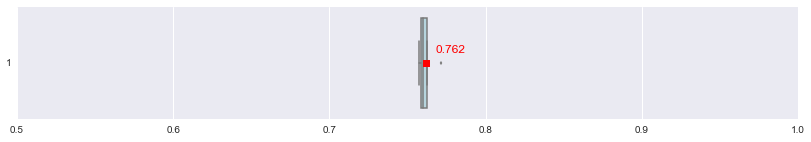

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,2))
sns.boxplot(scores, vert=False, color='lightblue', ax=axes, showmeans=True)
axes.annotate('{:.3f}'.format(np.mean(scores)), xy=(np.mean(scores),1), xycoords='data'
                 ,xytext=(10, 10), textcoords='offset points', color='r', fontsize=12)
axes.set_xlim([0.5,1])

---
<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>